In [83]:
import numpy as np
import numpy.linalg
import scipy
# Plot 3D drone location and velocity vector
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
%matplotlib inline

In [2]:
# drone
# position vector
x = 1
y = 1
h = 1
r = np.array([x, y, h])

In [222]:
ground_stations=[[0, 0, 0], [5, 0, 0], [0, 5, 0], [0, 10, 0], [10,0,0], [10,10,0], [10, 5, 0], [5, 10, 0]]

In [223]:
def get_drone(observed_freq, ground_stations):

    # Constants
    c = 343  # Speed of sound (m/s)
    
    # Inputs
    frequencies = observed_freq  # Observed frequencies at microphones (Hz)
    mic_positions = ground_stations  # Microphone positions (x, y)
    
    # Normalize frequencies to remove f_s
    f_ratios = [frequencies[i] / frequencies[0] for i in range(1, len(frequencies))]
    
    # Define the residual function
    def residuals(params):
        x_d, y_d, h, v_x, v_y, v_h = params
        res = []
        
        for i in range(1, len(mic_positions)-1):
            # Positions
            x_i, y_i, z_i = mic_positions[i]
            x_j, y_j, z_j = mic_positions[0]
            
            # Distances
            r_i = np.sqrt((x_d - x_i)**2 + (y_d - y_i)**2 + h**2)
            r_j = np.sqrt((x_d - x_j)**2 + (y_d - y_j)**2 + h**2)
            
            # Relative velocities
            v_par_i = -(v_x * (x_d - x_i) + v_y * (y_d - y_i) + v_h * h) / r_i
            v_par_j = -(v_x * (x_d - x_j) + v_y * (y_d - y_j) + v_h * h) / r_j
            
            # Doppler shift ratios
            doppler_ratio = (c - v_par_j) / (c - v_par_i)
    
            # Residual: difference between calculated and observed ratios
            res.append(doppler_ratio - f_ratios[i - 1])
        
        return res
    
    # Initial guesses for optimization
    initial_guess = [0.5, 0.5, 1.0, 0.0, 0.0, 0.0]
    
    # Solve the system of equations
    result = least_squares(residuals, initial_guess)
    
    # Output the results
    x_d, y_d, h, v_x, v_y, v_h = result.x
    print(f"Drone position: ({x_d:.2f}, {y_d:.2f}, {h:.2f})")
    print(f"Drone velocity: ({v_x:.2f}, {v_y:.2f}, {v_h:.2f})")
    return result.x

In [224]:
d_pos_true
d_vel_true

[20, 0, 0]

In [225]:
# Constants
c = 343  # Speed of sound in m/s (at 20°C)
d_state_true = [5, 5, 5, 20, 0, 0] #m
d_pos_true = d_state_true[:3]
d_vel_true = d_state_true[3:] #m/s
# Inputs
drone_position = np.array(d_pos_true)  # Position of the drone (x_d, y_d, h)
drone_velocity = np.array(d_vel_true)  # Velocity of the drone (v_x, v_y, v_h)
microphone_positions = np.array(ground_stations)  # Positions of microphones
source_frequency = 6000  # Source frequency emitted by the drone

# Function to compute Doppler shift for each microphone
def doppler_shift(drone_position, drone_velocity, microphone_positions, source_frequency):
    frequencies = []
    
    for mic_pos in microphone_positions:
        # Compute the vector from the drone to the microphone
        r_i = mic_pos - drone_position  # Ignore z for the microphone (ground level)
        # r_i = np.append(r_i, -drone_position[2])  # Add height difference (h) to the z-component
        
        # Compute the relative velocity component along the line of sight
        v_parallel_i = np.dot(drone_velocity, r_i) / np.linalg.norm(r_i)
        
        # Compute the observed frequency at the microphone using the Doppler effect
        observed_frequency = source_frequency * (c / (c - v_parallel_i))
        frequencies.append(observed_frequency)
    
    return frequencies

# Compute frequencies for each microphone
observed_frequencies = doppler_shift(drone_position, drone_velocity, microphone_positions, source_frequency)
drone_state_mes = get_drone(observed_frequencies, ground_stations)

# Output the results
print("Observed Frequencies:", observed_frequencies)


Drone position: (5.00, 5.00, 5.00)
Drone velocity: (20.00, 0.00, -0.00)
Observed Frequencies: [5804.589994413412, 6000.0, 5762.411641532594, 5804.589994413412, 6209.025211502395, 6209.025211502395, 6258.0227597820185, 6000.0]


In [226]:
def get_error(mes, true):
    residuals = true - mes
    return np.sum(np.square(residuals))

In [227]:
get_error(d_state_true, drone_state_mes)

4.291807905489749e-09

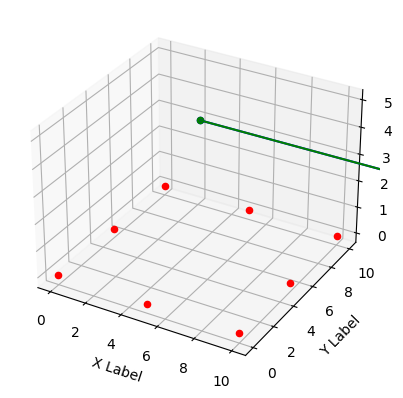

In [228]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
x_d, y_d, h, vx_d, vy_d, vh_d = drone_state_mes
# predicted position
ax.quiver(*drone_state_mes, color="blue")
ax.scatter(x_d, y_d, h, color="blue")

# true position
ax.quiver(*d_pos_true, *d_vel_true, color="green")
ax.scatter(*d_pos_true, color="green")

# position of ground stations
for i in range(len(ground_stations)):
    ax.scatter(*ground_stations[i], color="red")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


# Doppler Effect Equations

### 1. Doppler Effect Equation:

$$
f_i = f_s \cdot \frac{c}{c - v_{\parallel i}}
$$

where:
- \( f_i \) is the observed frequency at microphone \( i \),
- \( f_s \) is the source frequency,
- \( c \) is the speed of sound,
- \( v_{\parallel i} \) is the component of the drone’s velocity along the line of sight to the microphone \( i \).

---

### 2. Relative Velocity Component:

$$
v_{\parallel i} = \frac{v_x (x_d - x_i) + v_y (y_d - y_i) + v_h \cdot h}{\sqrt{(x_d - x_i)^2 + (y_d - y_i)^2 + h^2}}
$$

where:
- \( (x_d, y_d, h) \) is the position of the drone,
- \( (x_i, y_i) \) is the position of the \( i \)-th microphone,
- \( v_x, v_y, v_h \) are the components of the drone's velocity.

---

### 3. Normalized Doppler Shift Ratio:

$$
\frac{f_i}{f_j} = \frac{c - v_{\parallel j}}{c - v_{\parallel i}}
$$

where:
- \( f_i \) and \( f_j \) are the observed frequencies at microphones \( i \) and \( j \),
- \( v_{\parallel i} \) and \( v_{\parallel j} \) are the relative velocity components at microphones \( i \) and \( j \).

---

### 4. Distance Between Drone and Microphone:

$$
r_i = \sqrt{(x_d - x_i)^2 + (y_d - y_i)^2 + h^2}
$$

---

### 5. System of Nonlinear Equations:

$$
\frac{f_i}{f_j} = \frac{c - \frac{v_x (x_d - x_j) + v_y (y_d - y_j) + v_h \cdot h}{r_j}}{c - \frac{v_x (x_d - x_i) + v_y (y_d - y_i) + v_h \cdot h}{r_i}}
$$

---

### 6. Initial Guess for the Optimization:

```python
initial_guess = [x_d, y_d, h, v_x, v_y, v_h]
```
